# COVID-19 Spread Analysis

In [197]:
import pandas as pd
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

## 1. Descriptive Analysis

The first section will provide general analysis of the COVID-19 crisis.

In [293]:
# Create a general Path object with time series data - We will also record the paths to the entire file names
path_to_time_series = Path('./csse_covid_19_data/csse_covid_19_time_series/')
path_to_support_data = Path('./csse_covid_19_data/support_data/')
file_world_pop_stats = path_to_support_data / '2020_World_Population_Stats.xlsx' # Read in data file regarding world populations. 
csv_confirmed_cases = path_to_time_series / 'time_series_19-covid-Confirmed.csv'    # CSV regarding number of confirmed cases over time
file_deaths = path_to_time_series / 'time_series_19-covid-Deaths.csv'  # Read the csv file regarding number of deaths over time

In [294]:
# One time read-ins (All data support files that only need to be read in once will be stored here)
df_count_pops = pd.read_excel(file_world_pop_stats)

In [295]:
# The following cell will contain useful functions available for the remaining

def get_country_pops(country_list, country_df):
    
    # Function Description: Given a list of populations, find the population for each country.
    # Function Parameters: country_list (The list of countries), country_df (The data frame holding the countries values)
    # Function Returns: pop_dict (The population of each country in a dictionary format)
    # Function Throws: Nothing
    
    populations = {}
    for country in country_list:
        populations[country] = country_df.loc[country_df['Country_Name'] == country]['Population-2020']
    return populations

def get_country_last_col_val(country_list, df):
    
    # Function Description: Return the sums in a dictionary format for indicated columns in a dataframe.
    # Function Parameters: country_list (The list of countries), df (The data frame holding the countries values)
    # Function Returns: sum_dict (The sums and their associated column names)
    # Function Throws: Nothing
    
    summations = {}
    for country in country_list:
        summations[country] = df[country].iloc[-1]
    return summations

def generic_plt_functions(plt, x_label, y_label, title, df):
    
    # Function Description: Perform common actions on a graph before deploying.
    # Function Parameters: plt (The graph plot to manipulate), x_label (The label of the x axis), 
    #     y_label (The label of the y axis), title (The plots title), df (The actual df)
    # Function Returns: plt (The modified plot graph)
    # Function Throws: Nothing
    
    plt.set_ylabel(y_label)
    plt.set_xlabel(x_label)
    plt.set_title(title)
    xticks_locs = [i for i in range(0, len(df.index.tolist()), 2)]
    xticks = df.index.tolist()
    xticks = xticks[::2]
    plt.set_xticks(xticks_locs, minor=False)
    plt.set_xticklabels(xticks, fontdict=None, minor=False, rotation=90)
    plt.legend(loc=(1.04,0))
    return plt

def common_mappings_on_corona_data(file_name, groupby_label=None, drop_cols=None, filter_countries=None):
    
    # Function Description: Perform common transfirmations on the data that are specific to these datasets.
    # Function Parameters: file_name (The name of the file containing the data), 
    #     groupby_label (The name of the label in which to groupby (Default: None - No group by performed)), 
    #     drop_cols (The columns that will be dropped (Default: None - No drops will be performed)), 
    #     filter_countries (The countries that we will filter (Default: None - No filters will be performed))
    # Function Throws: Nothing
    # Function Returns: df (The adjusted dataframe)
    
    df = pd.read_csv(file_name)       # Reduce scope size to country and transpose dataframe 
    if groupby_label: df = df.groupby([groupby_label], as_index=False).sum()
    if drop_cols: df = df.drop(columns=drop_cols)
    df = df.transpose()
    new_header = df.iloc[0]           # Set the header row as the df header
    df = df[1:]                     
    df.columns = new_header           
    df.index.names = ['Time']
    if filter_countries: df = df.filter(items=filter_countries)    # Filter the df with columns names
    return df

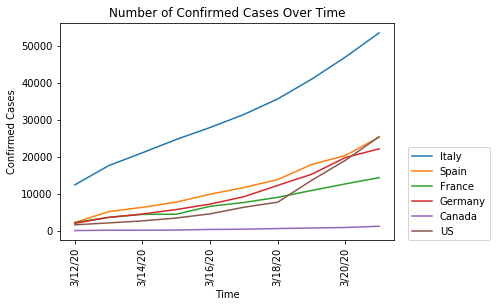

In [296]:
# Plot number of confirmed cases in specific regions
euro_countries = ['Italy', 'Spain', 'France', 'Germany', 'Canada', 'US']
df = common_mappings_on_corona_data(csv_confirmed_cases, groupby_label='Country/Region', 
                                   drop_cols=['Lat', 'Long'], filter_countries=euro_countries)
df = df[-10:]
plt = df.plot()
plt = generic_plt_functions(plt, 'Time', 'Confirmed Cases', 'Number of Confirmed Cases Over Time', df)

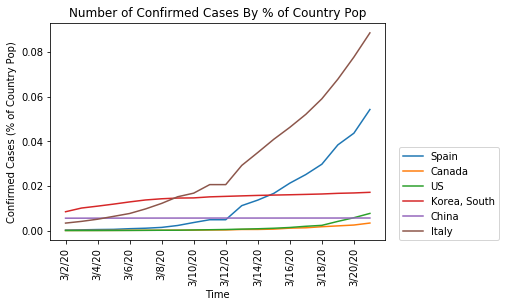

In [297]:
# Filter for only European Countries
countries_list = ['Spain', 'Canada', 'US', 'Korea, South', 'China', 'Italy']
df = common_mappings_on_corona_data(csv_confirmed_cases, groupby_label='Country/Region', 
                                   drop_cols=['Lat', 'Long'], filter_countries=countries_list)
df = df[-20:]
# Apply a transformation to European Columns
country_pops = get_country_pops(countries_list, df_count_pops)
for country, den in country_pops.items():
    df[country] = df[country].apply(lambda x: (x / den) * 100)
plt = df.plot()
generic_plt_functions(plt, 'Time', 'Confirmed Cases (% of Country Pop)', 'Number of Confirmed Cases By % of Country Pop', df)

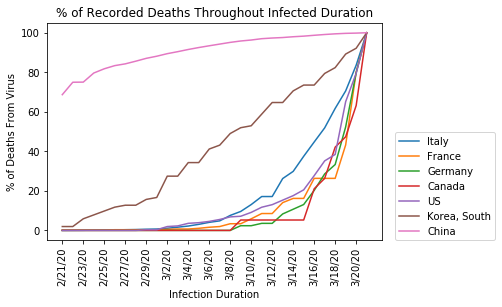

In [292]:
countries_list = ['Italy', 'France', 'Germany', 'Canada', 'US', 'Korea, South', 'China']
df = common_mappings_on_corona_data(file_deaths, groupby_label='Country/Region', 
        drop_cols=['Lat', 'Long'], 
        filter_countries=countries_list)
df = df[-30:]
country_deaths = get_country_last_col_val(countries_list, df)
for country, pop in country_deaths.items():
    df[country] = df[country].apply(lambda x: (x / pop) * 100)
plt = df.plot()
generic_plt_functions(plt, 'Infection Duration', 
                      '% of Deaths From Virus', '% of Recorded Deaths Throughout Infected Duration', df)

In [283]:
countries_list = ['Italy', 'US']
df_per_cases = common_mappings_on_corona_data(csv_confirmed_cases, groupby_label='Country/Region', drop_cols=['Lat', 'Long'], filter_countries=countries_list)
df_deaths = common_mappings_on_corona_data(file_deaths, groupby_label='Country/Region', drop_cols=['Lat', 'Long'], filter_countries=countries_list)
df_deaths = df_deaths[-20:]
df_per_cases = df_per_cases[-20:]
df_per_cases = df_per_cases.reset_index()
country_pops = get_country_pops(countries_list, df_count_pops)
for country, den in country_pops.items():
    df_per_cases[country] = df_per_cases[country].apply(lambda x: (x / den) * 100)
    df_deaths[country] = df_deaths[country].apply(lambda x: (x / den) * 100)

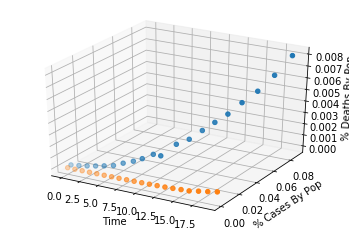

In [284]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(df_per_cases.index, df_per_cases['Italy'], df_deaths['Italy'])
threedee.scatter(df_per_cases.index, df_per_cases['US'], df_deaths['US'])
threedee.set_xlabel('Time')
threedee.set_ylabel('% Cases By Pop')
threedee.set_zlabel('% Deaths By Pop')
plt.show()

In [287]:
for ii in xrange(0,360,1):
    threedee.view_init(elev=10., azim=ii)
    savefig("C:\Users\micha\Desktop\a.png" % ii)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-287-b8b92d279090>, line 3)